<a href="https://colab.research.google.com/github/ArmandDS/bert_for_long_text/blob/master/final_bert_long_docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub

Using TensorFlow backend.
/home/noah/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/noah/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/noah/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/noah/anaconda3/lib/python3.7/site-packages/tensorflow/py

# Loading The Data

In [2]:
train_raw = pd.read_csv('./data/train.csv', header=None, names=['class', 'text'])
train_raw.head()

,class,text
0,0,\n\n#ifndef _WIN32\n#include <wchar.h>\n#endif...
1,0,"#include ""std_testcase.h""\n\ntypedef struct _l..."
2,18,\n\n#include <wchar.h>\n#include <list>\n#incl...
3,123,"#include ""std_testcase.h""\n\n#include <wchar.h..."
4,16,"#include ""std_testcase.h""\n\n#include <wchar.h..."


In [3]:
train_raw.shape

(102312, 2)

# Preprocessing Data

Select non null:

In [4]:
train_raw = train_raw[train_raw.text.notnull()]
train_raw.shape

(102312, 2)

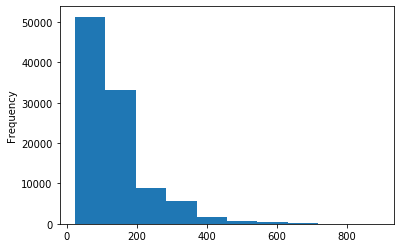

In [5]:
train_raw.text.apply(lambda x: len(x.split())).plot(kind='hist')

In [6]:
train_raw['len_txt'] =train_raw.text.apply(lambda x: len(x.split()))
train_raw.describe()

,class,len_txt
count,102312.000000,102312.000000
mean,24.679539,138.020956
std,36.690807,95.520252
min,0.000000,23.000000
25%,0.000000,76.000000
50%,0.000000,109.000000
75%,45.000000,159.000000
max,123.000000,892.000000


In [7]:
train_raw.shape

(102312, 3)

Select only the row with number of words greater than 250:

In [8]:
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(12297, 3)

In [9]:
train_raw = train_raw[['text', 'class']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,text,class
0,\n\n#ifndef _WIN32\n#include <wchar.h>\n#endif...,0
1,"#include ""std_testcase.h""\n\n#ifdef _WIN32\n#i...",26
2,\n\n#ifdef _WIN32\n#include <winsock2.h>\n#inc...,44
3,"#include ""std_testcase.h""\n\n#ifdef _WIN32\n#i...",90
4,"#include ""std_testcase.h""\n\n#define MAX_LOOP ...",47


Group similar products

In [10]:
# train_raw.at[train_raw['product'] == 'Credit reporting', 'product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
# train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
# train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
# train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
# train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,text,class
0,\n\n#ifndef _WIN32\n#include <wchar.h>\n#endif...,0
1,"#include ""std_testcase.h""\n\n#ifdef _WIN32\n#i...",26
2,\n\n#ifdef _WIN32\n#include <winsock2.h>\n#inc...,44
3,"#include ""std_testcase.h""\n\n#ifdef _WIN32\n#i...",90
4,"#include ""std_testcase.h""\n\n#define MAX_LOOP ...",47


In [11]:
for l in np.unique(train_raw['class']):
  print(l)

0
8
10
12
17
19
25
26
35
40
41
44
45
47
51
57
58
59
70
71
73
75
83
85
90
91
92
93
98
100
101
103
105
108
112
117
122
123


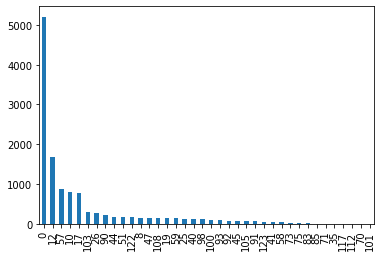

In [12]:
train_raw['class'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [13]:
train_raw=train_raw.rename(columns = {'text':'text', 'class':'label'})
train_raw.head()

,text,label
0,\n\n#ifndef _WIN32\n#include <wchar.h>\n#endif...,0
1,"#include ""std_testcase.h""\n\n#ifdef _WIN32\n#i...",26
2,\n\n#ifdef _WIN32\n#include <winsock2.h>\n#inc...,44
3,"#include ""std_testcase.h""\n\n#ifdef _WIN32\n#i...",90
4,"#include ""std_testcase.h""\n\n#define MAX_LOOP ...",47


In [14]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,\n\n#ifndef _WIN32\n#include <wchar.h>\n#endif...,0
1,"#include ""std_testcase.h""\n\n#ifdef _WIN32\n#i...",7
2,\n\n#ifdef _WIN32\n#include <winsock2.h>\n#inc...,11
3,"#include ""std_testcase.h""\n\n#ifdef _WIN32\n#i...",24
4,"#include ""std_testcase.h""\n\n#define MAX_LOOP ...",13


In [15]:
len(np.unique(train_raw['label']))

38

In [16]:
train = train_raw.copy()

In [17]:
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
47,#include <map>\n\n#ifdef _WIN32\n#define BASEP...,2
9330,\n\n#ifdef _WIN32\n#include <winsock2.h>\n#inc...,27
9318,\n\n#ifdef _WIN32\n#include <winsock2.h>\n#inc...,7
2594,"#include <stdarg.h>\n#include ""std_testcase.h""...",0
6621,"#include ""std_testcase.h""\n\n#ifndef _WIN32\n#...",15


Clean the text columns

In [18]:
import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text

In [19]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
47,include map ifdef _WIN32 define BASEPATH c te...,2
9330,ifdef _WIN32 include winsock2 h include windo...,27
9318,ifdef _WIN32 include winsock2 h include windo...,7
2594,include stdarg h include std_testcase h ifnde...,0
6621,include std_testcase h ifndef _WIN32 include ...,15


In [20]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label
11922,include std_testcase h ifdef _WIN32 include w...,0
11326,ifdef _WIN32 define BASEPATH L c temp else in...,2
10957,include std_testcase h include wchar h ifdef ...,36
11606,include std_testcase h include wchar h includ...,0
8579,include std_testcase h ifdef _WIN32 include w...,0


In [21]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,include std_testcase h ifdef _WIN32 include w...,0
1,ifdef _WIN32 define BASEPATH L c temp else in...,2


In [22]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label
0,include wchar h ifdef _WIN32 define FULL_COMM...,0
1,ifdef _WIN32 include winsock2 h include windo...,7


In [23]:
val.shape, train.shape

((2460, 2), (9837, 2))

In [24]:
#Installing BERT module
# !pip install tensorflow==1.15.0

In [25]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

# Setting The Output Directory for BERT

In [26]:
# Set the output directory for saving model file
OUTPUT_DIR = './bert_code_category'

# #@markdown Whether or not to clear/delete the directory and create a new one
# DO_DELETE = True #@param {type:"boolean"}

# if DO_DELETE:
#   try:
#     tf.gfile.DeleteRecursively(OUTPUT_DIR)
#   except:
#     pass

# tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: ./bert_code_category *****


In [27]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (9837, 2)
Validation Set Shape : (2460, 2)


In [28]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37]

# Splitting the Data into smaller chunks

In [29]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [30]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,include std_testcase h ifdef _WIN32 include w...,0,[include std_testcase h ifdef _WIN32 include w...
1,ifdef _WIN32 define BASEPATH L c temp else in...,2,[ifdef _WIN32 define BASEPATH L c temp else in...
2,include std_testcase h include wchar h ifdef ...,36,[include std_testcase h include wchar h ifdef ...
3,include std_testcase h include wchar h includ...,0,[include std_testcase h include wchar h includ...
4,include std_testcase h ifdef _WIN32 include w...,0,[include std_testcase h ifdef _WIN32 include w...


In [31]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,text_split
0,include wchar h ifdef _WIN32 define FULL_COMM...,0,[include wchar h ifdef _WIN32 define FULL_COMM...
1,ifdef _WIN32 include winsock2 h include windo...,7,[ifdef _WIN32 include winsock2 h include windo...


In [32]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(16103, 16103, 16103)

In [33]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(4000, 4000, 4000)

The final dataset for training:

In [34]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,include std_testcase h ifdef _WIN32 include wi...,0
1,ifdef _WIN32 define BASEPATH L c temp else inc...,2
2,getenv endif ifdef _WIN32 define OPEN _wopen d...,2
3,include std_testcase h include wchar h ifdef _...,36
4,include std_testcase h include wchar h include...,0


In [35]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,include wchar h ifdef _WIN32 define FULL_COMMA...,0
1,h define INVALID_SOCKET 1 define SOCKET_ERROR ...,0
2,ifdef _WIN32 include winsock2 h include window...,7
3,include wchar h ifdef _WIN32 include winsock2 ...,0
4,TCP_PORT 27015 define LISTEN_BACKLOG 5 define ...,0


# BERT: Data Preprocessing 

Process the data for BERT

In [36]:
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [37]:
train_InputExamples

0        <bert.run_classifier.InputExample object at 0x...
1        <bert.run_classifier.InputExample object at 0x...
2        <bert.run_classifier.InputExample object at 0x...
3        <bert.run_classifier.InputExample object at 0x...
4        <bert.run_classifier.InputExample object at 0x...
                               ...                        
16098    <bert.run_classifier.InputExample object at 0x...
16099    <bert.run_classifier.InputExample object at 0x...
16100    <bert.run_classifier.InputExample object at 0x...
16101    <bert.run_classifier.InputExample object at 0x...
16102    <bert.run_classifier.InputExample object at 0x...
Length: 16103, dtype: object

In [38]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  include std_testcase h ifdef _WIN32 include winsock2 h include windows h include direct h pragma comment lib ws2_32 define CLOSE_SOCKET closesocket else include sys types h include sys socket h include netinet in h include arpa inet h include unistd h define INVALID_SOCKET 1 define SOCKET_ERROR 1 define CLOSE_SOCKET close define SOCKET int endif define TCP_PORT 27015 define IP_ADDRESS 127 0 0 1 define CHAR_ARRAY_SIZE 3 sizeof data 2 static void func3 int data int result data 1 printIntLine result static void func4 int data void funcPtr int func3 data 0 data 2 funcPtr data static void func5 int data if data INT_MIN int result data 1 printIntLine result else printLine data value is too large to perform subtraction static void func6 int data void funcPtr int func5 data 0 ifdef _WIN32 WSADATA wsaData int wsaDataInit 0 endif int recvResult struct sockaddr_in service SOCKET connectSocket INVALID_SOCKET char in

# BERT: Loading the pre-trained model

In [39]:

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [40]:
len(tokenizer.vocab.keys())

30522

In [41]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['include', 'st', '##d', '_', 'test', '##case', 'h', 'if', '##de', '##f', '_', 'win', '##32', 'include', 'wins', '##ock', '##2', 'h', 'include', 'windows', 'h', 'include', 'direct', 'h', 'pr', '##ag', '##ma', 'comment', 'li', '##b', 'w', '##s', '##2', '_', '32', 'define', 'close', '_', 'socket', 'closes', '##ock', '##et', 'else', 'include', 'sy', '##s', 'types', 'h', 'include', 'sy', '##s', 'socket', 'h', 'include', 'net', '##ine', '##t', 'in', 'h', 'include', 'ar', '##pa', 'in', '##et', 'h', 'include', 'un', '##ist', '##d', 'h', 'define', 'invalid', '_', 'socket', '1', 'define', 'socket', '_', 'error', '1', 'define', 'close', '_', 'socket', 'close', 'define', 'socket', 'int', 'end', '##if', 'define', 'tc', '##p', '_', 'port', '270', '##15', 'define', 'ip', '_', 'address', '127', '0', '0', '1', 'define', 'char', '_', 'array', '_', 'size', '3', 'size', '##of', 'data', '2', 'static', 'void', 'fun', '##c', '##3', 'int', 'data', 'int', 'result', 'data', '1', 'print', '##int', '##line', 're

In [42]:
MAX_SEQ_LENGTH = 200

In [43]:
# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 16103


INFO:tensorflow:Writing example 0 of 16103


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] include st ##d _ test ##case h if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h include un ##ist ##d h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define ip _ address 127 0 0 1 define char _ array _ size 3 size ##of data 2 static void fun ##c ##3 int data int result data 1 print ##int ##line result static void fun ##c ##4 int data void fun ##cp ##tr int fun ##c ##3 data 0 data 2 fun ##cp ##tr data static void fun ##c ##5 int data if data int _ min int result data 1 print ##int ##line result else print ##line data value is too large to perform sub ##tra ##ction static void fun ##c ##6 int data void fun ##cp ##tr [SEP]


INFO:tensorflow:tokens: [CLS] include st ##d _ test ##case h if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h include un ##ist ##d h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define ip _ address 127 0 0 1 define char _ array _ size 3 size ##of data 2 static void fun ##c ##3 int data int result data 1 print ##int ##line result static void fun ##c ##4 int data void fun ##cp ##tr int fun ##c ##3 data 0 data 2 fun ##cp ##tr data static void fun ##c ##5 int data if data int _ min int result data 1 print ##int ##line result else print ##line data value is too large to perform sub ##tra ##ction static void fun ##c ##6 int data void fun ##cp ##tr [SEP]


INFO:tensorflow:input_ids: 101 2421 2358 2094 1035 3231 18382 1044 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 2421 4895 2923 2094 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 12997 1035 4769 13029 1014 1014 1015 9375 25869 1035 9140 1035 2946 1017 2946 11253 2951 1016 10763 11675 4569 2278 2509 20014 2951 20014 2765 2951 1015 6140 18447 4179 2765 10763 11675 4569 2278 2549 20014 2951 11675 4569 21906 16344 20014 4569 2278 2509 2951 1014 2951 1016 4569 21906 16344 2951 10763 11675 4569 2278 2629 20014 2951 2065 2951 20014 1035 8117 20014 2765 2951 1015 6140 18447 4179 2765 2842 6140 4179 2951 3643 2003 2205 2312 2000 4685 4942 6

INFO:tensorflow:input_ids: 101 2421 2358 2094 1035 3231 18382 1044 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 2421 4895 2923 2094 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 12997 1035 4769 13029 1014 1014 1015 9375 25869 1035 9140 1035 2946 1017 2946 11253 2951 1016 10763 11675 4569 2278 2509 20014 2951 20014 2765 2951 1015 6140 18447 4179 2765 10763 11675 4569 2278 2549 20014 2951 11675 4569 21906 16344 20014 4569 2278 2509 2951 1014 2951 1016 4569 21906 16344 2951 10763 11675 4569 2278 2629 20014 2951 2065 2951 20014 1035 8117 20014 2765 2951 1015 6140 18447 4179 2765 2842 6140 4179 2951 3643 2003 2205 2312 2000 4685 4942 6

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] if ##de ##f _ win ##32 define base ##path l c te ##mp else include wc ##har h define base ##path l t ##mp end ##if define en ##v _ variable l add if ##de ##f _ win ##32 define get ##en ##v _ w ##get ##en ##v else define get ##en ##v get ##en ##v end ##if if ##de ##f _ win ##32 define open _ wo ##pen define close _ close else include un ##ist ##d h define open open define close close end ##if names ##pace gen ##ns ##1 void fun ##c ##3 wc ##har _ t data void fun ##c ##1 wc ##har _ t data fun ##c ##3 data if ##de ##f _ win ##32 define base ##path l c te ##mp else include wc ##har h define base ##path l t ##mp end ##if define en ##v _ variable l add if ##de ##f _ win ##32 define get ##en ##v _ w ##get ##en ##v else define get ##en ##v get ##en ##v end ##if if ##de ##f _ win ##32 define open _ wo ##pen define close _ close else include un ##ist ##d h define open open define close [SEP]


INFO:tensorflow:tokens: [CLS] if ##de ##f _ win ##32 define base ##path l c te ##mp else include wc ##har h define base ##path l t ##mp end ##if define en ##v _ variable l add if ##de ##f _ win ##32 define get ##en ##v _ w ##get ##en ##v else define get ##en ##v get ##en ##v end ##if if ##de ##f _ win ##32 define open _ wo ##pen define close _ close else include un ##ist ##d h define open open define close close end ##if names ##pace gen ##ns ##1 void fun ##c ##3 wc ##har _ t data void fun ##c ##1 wc ##har _ t data fun ##c ##3 data if ##de ##f _ win ##32 define base ##path l c te ##mp else include wc ##har h define base ##path l t ##mp end ##if define en ##v _ variable l add if ##de ##f _ win ##32 define get ##en ##v _ w ##get ##en ##v else define get ##en ##v get ##en ##v end ##if if ##de ##f _ win ##32 define open _ wo ##pen define close _ close else include un ##ist ##d h define open open define close [SEP]


INFO:tensorflow:input_ids: 101 2065 3207 2546 1035 2663 16703 9375 2918 15069 1048 1039 8915 8737 2842 2421 15868 8167 1044 9375 2918 15069 1048 1056 8737 2203 10128 9375 4372 2615 1035 8023 1048 5587 2065 3207 2546 1035 2663 16703 9375 2131 2368 2615 1035 1059 18150 2368 2615 2842 9375 2131 2368 2615 2131 2368 2615 2203 10128 2065 3207 2546 1035 2663 16703 9375 2330 1035 24185 11837 9375 2485 1035 2485 2842 2421 4895 2923 2094 1044 9375 2330 2330 9375 2485 2485 2203 10128 3415 15327 8991 3619 2487 11675 4569 2278 2509 15868 8167 1035 1056 2951 11675 4569 2278 2487 15868 8167 1035 1056 2951 4569 2278 2509 2951 2065 3207 2546 1035 2663 16703 9375 2918 15069 1048 1039 8915 8737 2842 2421 15868 8167 1044 9375 2918 15069 1048 1056 8737 2203 10128 9375 4372 2615 1035 8023 1048 5587 2065 3207 2546 1035 2663 16703 9375 2131 2368 2615 1035 1059 18150 2368 2615 2842 9375 2131 2368 2615 2131 2368 2615 2203 10128 2065 3207 2546 1035 2663 16703 9375 2330 1035 24185 11837 9375 2485 1035 2485 2842 2

INFO:tensorflow:input_ids: 101 2065 3207 2546 1035 2663 16703 9375 2918 15069 1048 1039 8915 8737 2842 2421 15868 8167 1044 9375 2918 15069 1048 1056 8737 2203 10128 9375 4372 2615 1035 8023 1048 5587 2065 3207 2546 1035 2663 16703 9375 2131 2368 2615 1035 1059 18150 2368 2615 2842 9375 2131 2368 2615 2131 2368 2615 2203 10128 2065 3207 2546 1035 2663 16703 9375 2330 1035 24185 11837 9375 2485 1035 2485 2842 2421 4895 2923 2094 1044 9375 2330 2330 9375 2485 2485 2203 10128 3415 15327 8991 3619 2487 11675 4569 2278 2509 15868 8167 1035 1056 2951 11675 4569 2278 2487 15868 8167 1035 1056 2951 4569 2278 2509 2951 2065 3207 2546 1035 2663 16703 9375 2918 15069 1048 1039 8915 8737 2842 2421 15868 8167 1044 9375 2918 15069 1048 1056 8737 2203 10128 9375 4372 2615 1035 8023 1048 5587 2065 3207 2546 1035 2663 16703 9375 2131 2368 2615 1035 1059 18150 2368 2615 2842 9375 2131 2368 2615 2131 2368 2615 2203 10128 2065 3207 2546 1035 2663 16703 9375 2330 1035 24185 11837 9375 2485 1035 2485 2842 2

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] get ##en ##v end ##if if ##de ##f _ win ##32 define open _ wo ##pen define close _ close else include un ##ist ##d h define open open define close close end ##if names ##pace gen ##ns ##1 void fun ##c ##7 wc ##har _ t data void fun ##c ##5 wc ##har _ t data fun ##c ##7 data if ##de ##f _ win ##32 define base ##path l c te ##mp else include wc ##har h define base ##path l t ##mp end ##if define en ##v _ variable l add if ##de ##f _ win ##32 define get ##en ##v _ w ##get ##en ##v else define get ##en ##v get ##en ##v end ##if if ##de ##f _ win ##32 define open _ wo ##pen define close _ close else include un ##ist ##d h define open open define close close end ##if names ##pace gen ##ns ##1 void fun ##c ##7 wc ##har _ t data int filed ##es ##c filed ##es ##c open data o _ rd ##wr o _ cr ##ea ##t s _ ir ##ead s _ i ##write if filed ##es ##c 1 close filed ##es ##c if [SEP]


INFO:tensorflow:tokens: [CLS] get ##en ##v end ##if if ##de ##f _ win ##32 define open _ wo ##pen define close _ close else include un ##ist ##d h define open open define close close end ##if names ##pace gen ##ns ##1 void fun ##c ##7 wc ##har _ t data void fun ##c ##5 wc ##har _ t data fun ##c ##7 data if ##de ##f _ win ##32 define base ##path l c te ##mp else include wc ##har h define base ##path l t ##mp end ##if define en ##v _ variable l add if ##de ##f _ win ##32 define get ##en ##v _ w ##get ##en ##v else define get ##en ##v get ##en ##v end ##if if ##de ##f _ win ##32 define open _ wo ##pen define close _ close else include un ##ist ##d h define open open define close close end ##if names ##pace gen ##ns ##1 void fun ##c ##7 wc ##har _ t data int filed ##es ##c filed ##es ##c open data o _ rd ##wr o _ cr ##ea ##t s _ ir ##ead s _ i ##write if filed ##es ##c 1 close filed ##es ##c if [SEP]


INFO:tensorflow:input_ids: 101 2131 2368 2615 2203 10128 2065 3207 2546 1035 2663 16703 9375 2330 1035 24185 11837 9375 2485 1035 2485 2842 2421 4895 2923 2094 1044 9375 2330 2330 9375 2485 2485 2203 10128 3415 15327 8991 3619 2487 11675 4569 2278 2581 15868 8167 1035 1056 2951 11675 4569 2278 2629 15868 8167 1035 1056 2951 4569 2278 2581 2951 2065 3207 2546 1035 2663 16703 9375 2918 15069 1048 1039 8915 8737 2842 2421 15868 8167 1044 9375 2918 15069 1048 1056 8737 2203 10128 9375 4372 2615 1035 8023 1048 5587 2065 3207 2546 1035 2663 16703 9375 2131 2368 2615 1035 1059 18150 2368 2615 2842 9375 2131 2368 2615 2131 2368 2615 2203 10128 2065 3207 2546 1035 2663 16703 9375 2330 1035 24185 11837 9375 2485 1035 2485 2842 2421 4895 2923 2094 1044 9375 2330 2330 9375 2485 2485 2203 10128 3415 15327 8991 3619 2487 11675 4569 2278 2581 15868 8167 1035 1056 2951 20014 6406 2229 2278 6406 2229 2278 2330 2951 1051 1035 16428 13088 1051 1035 13675 5243 2102 1055 1035 20868 13775 1055 1035 1045 263

INFO:tensorflow:input_ids: 101 2131 2368 2615 2203 10128 2065 3207 2546 1035 2663 16703 9375 2330 1035 24185 11837 9375 2485 1035 2485 2842 2421 4895 2923 2094 1044 9375 2330 2330 9375 2485 2485 2203 10128 3415 15327 8991 3619 2487 11675 4569 2278 2581 15868 8167 1035 1056 2951 11675 4569 2278 2629 15868 8167 1035 1056 2951 4569 2278 2581 2951 2065 3207 2546 1035 2663 16703 9375 2918 15069 1048 1039 8915 8737 2842 2421 15868 8167 1044 9375 2918 15069 1048 1056 8737 2203 10128 9375 4372 2615 1035 8023 1048 5587 2065 3207 2546 1035 2663 16703 9375 2131 2368 2615 1035 1059 18150 2368 2615 2842 9375 2131 2368 2615 2131 2368 2615 2203 10128 2065 3207 2546 1035 2663 16703 9375 2330 1035 24185 11837 9375 2485 1035 2485 2842 2421 4895 2923 2094 1044 9375 2330 2330 9375 2485 2485 2203 10128 3415 15327 8991 3619 2487 11675 4569 2278 2581 15868 8167 1035 1056 2951 20014 6406 2229 2278 6406 2229 2278 2330 2951 1051 1035 16428 13088 1051 1035 13675 5243 2102 1055 1035 20868 13775 1055 1035 1045 263

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] include st ##d _ test ##case h include wc ##har h if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h include un ##ist ##d h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define ip _ address 127 0 0 1 define search _ char l ##s void fun ##c ##1 wc ##har _ t data data wc ##har _ t mall ##oc 100 size ##of wc ##har _ t if data null exit 1 data 0 l 0 if ##de ##f _ win ##32 w ##sa ##da ##ta w ##sa ##da ##ta int w ##sa ##da ##tain ##it 0 end ##if int rec ##vres ##ult st ##ru ##ct sock ##ad ##dr _ in service wc ##har _ t replace socket connects ##ock ##et invalid _ socket size _ t [SEP]


INFO:tensorflow:tokens: [CLS] include st ##d _ test ##case h include wc ##har h if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h include un ##ist ##d h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define ip _ address 127 0 0 1 define search _ char l ##s void fun ##c ##1 wc ##har _ t data data wc ##har _ t mall ##oc 100 size ##of wc ##har _ t if data null exit 1 data 0 l 0 if ##de ##f _ win ##32 w ##sa ##da ##ta w ##sa ##da ##ta int w ##sa ##da ##tain ##it 0 end ##if int rec ##vres ##ult st ##ru ##ct sock ##ad ##dr _ in service wc ##har _ t replace socket connects ##ock ##et invalid _ socket size _ t [SEP]


INFO:tensorflow:input_ids: 101 2421 2358 2094 1035 3231 18382 1044 2421 15868 8167 1044 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 2421 4895 2923 2094 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 12997 1035 4769 13029 1014 1014 1015 9375 3945 1035 25869 1048 2015 11675 4569 2278 2487 15868 8167 1035 1056 2951 2951 15868 8167 1035 1056 6670 10085 2531 2946 11253 15868 8167 1035 1056 2065 2951 19701 6164 1015 2951 1014 1048 1014 2065 3207 2546 1035 2663 16703 1059 3736 2850 2696 1059 3736 2850 2696 20014 1059 3736 2850 18249 4183 1014 2203 10128 20014 28667 24790 11314 2358 6820 6593 28407 4215 13626 1035 1999 2326 15868 8167 103

INFO:tensorflow:input_ids: 101 2421 2358 2094 1035 3231 18382 1044 2421 15868 8167 1044 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 2421 4895 2923 2094 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 12997 1035 4769 13029 1014 1014 1015 9375 3945 1035 25869 1048 2015 11675 4569 2278 2487 15868 8167 1035 1056 2951 2951 15868 8167 1035 1056 6670 10085 2531 2946 11253 15868 8167 1035 1056 2065 2951 19701 6164 1015 2951 1014 1048 1014 2065 3207 2546 1035 2663 16703 1059 3736 2850 2696 1059 3736 2850 2696 20014 1059 3736 2850 18249 4183 1014 2203 10128 20014 28667 24790 11314 2358 6820 6593 28407 4215 13626 1035 1999 2326 15868 8167 103

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 36 (id = 36)


INFO:tensorflow:label: 36 (id = 36)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] include st ##d _ test ##case h include wc ##har h include list include ios ##tream using names ##pace st ##d static con ##st int static _ con ##st _ five 5 names ##pace var ##1 static void fun ##c ##2 list int data if static _ con ##st _ five 5 data push _ back 100 data push _ back 0 if static _ con ##st _ five 5 print ##line benign fixed string else list int it ##era ##tor i co ##ut the list contains for i data begin i data end i co ##ut i co ##ut end ##l static void fun ##c ##3 list int data if static _ con ##st _ five 5 data push _ back 100 data push _ back 0 if static _ con ##st _ five 5 list int it ##era ##tor i co ##ut the list contains for i data begin i data end i co ##ut i co ##ut end ##l static void fun ##c ##4 list int data if static _ con ##st _ five 5 print ##line benign fixed string else data push _ back 100 data push _ back 200 if static _ con [SEP]


INFO:tensorflow:tokens: [CLS] include st ##d _ test ##case h include wc ##har h include list include ios ##tream using names ##pace st ##d static con ##st int static _ con ##st _ five 5 names ##pace var ##1 static void fun ##c ##2 list int data if static _ con ##st _ five 5 data push _ back 100 data push _ back 0 if static _ con ##st _ five 5 print ##line benign fixed string else list int it ##era ##tor i co ##ut the list contains for i data begin i data end i co ##ut i co ##ut end ##l static void fun ##c ##3 list int data if static _ con ##st _ five 5 data push _ back 100 data push _ back 0 if static _ con ##st _ five 5 list int it ##era ##tor i co ##ut the list contains for i data begin i data end i co ##ut i co ##ut end ##l static void fun ##c ##4 list int data if static _ con ##st _ five 5 print ##line benign fixed string else data push _ back 100 data push _ back 200 if static _ con [SEP]


INFO:tensorflow:input_ids: 101 2421 2358 2094 1035 3231 18382 1044 2421 15868 8167 1044 2421 2862 2421 16380 25379 2478 3415 15327 2358 2094 10763 9530 3367 20014 10763 1035 9530 3367 1035 2274 1019 3415 15327 13075 2487 10763 11675 4569 2278 2475 2862 20014 2951 2065 10763 1035 9530 3367 1035 2274 1019 2951 5245 1035 2067 2531 2951 5245 1035 2067 1014 2065 10763 1035 9530 3367 1035 2274 1019 6140 4179 28378 4964 5164 2842 2862 20014 2009 6906 4263 1045 2522 4904 1996 2862 3397 2005 1045 2951 4088 1045 2951 2203 1045 2522 4904 1045 2522 4904 2203 2140 10763 11675 4569 2278 2509 2862 20014 2951 2065 10763 1035 9530 3367 1035 2274 1019 2951 5245 1035 2067 2531 2951 5245 1035 2067 1014 2065 10763 1035 9530 3367 1035 2274 1019 2862 20014 2009 6906 4263 1045 2522 4904 1996 2862 3397 2005 1045 2951 4088 1045 2951 2203 1045 2522 4904 1045 2522 4904 2203 2140 10763 11675 4569 2278 2549 2862 20014 2951 2065 10763 1035 9530 3367 1035 2274 1019 6140 4179 28378 4964 5164 2842 2951 5245 1035 2067 2

INFO:tensorflow:input_ids: 101 2421 2358 2094 1035 3231 18382 1044 2421 15868 8167 1044 2421 2862 2421 16380 25379 2478 3415 15327 2358 2094 10763 9530 3367 20014 10763 1035 9530 3367 1035 2274 1019 3415 15327 13075 2487 10763 11675 4569 2278 2475 2862 20014 2951 2065 10763 1035 9530 3367 1035 2274 1019 2951 5245 1035 2067 2531 2951 5245 1035 2067 1014 2065 10763 1035 9530 3367 1035 2274 1019 6140 4179 28378 4964 5164 2842 2862 20014 2009 6906 4263 1045 2522 4904 1996 2862 3397 2005 1045 2951 4088 1045 2951 2203 1045 2522 4904 1045 2522 4904 2203 2140 10763 11675 4569 2278 2509 2862 20014 2951 2065 10763 1035 9530 3367 1035 2274 1019 2951 5245 1035 2067 2531 2951 5245 1035 2067 1014 2065 10763 1035 9530 3367 1035 2274 1019 2862 20014 2009 6906 4263 1045 2522 4904 1996 2862 3397 2005 1045 2951 4088 1045 2951 2203 1045 2522 4904 1045 2522 4904 2203 2140 10763 11675 4569 2278 2549 2862 20014 2951 2065 10763 1035 9530 3367 1035 2274 1019 6140 4179 28378 4964 5164 2842 2951 5245 1035 2067 2

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 16103


INFO:tensorflow:Writing example 10000 of 16103


INFO:tensorflow:Writing example 0 of 4000


INFO:tensorflow:Writing example 0 of 4000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] include wc ##har h if ##de ##f _ win ##32 define full _ command l dir else include un ##ist ##d h define full _ command l l ##s end ##if if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define listen _ back ##log 5 if ##de ##f _ win ##32 define pope ##n _ w ##pop ##en define pc ##los ##e _ pc ##los ##e else define pope ##n pope ##n define pc ##los ##e pc ##los ##e end ##if void fun ##c ##4 wc ##har _ t data void fun ##c ##2 wc ##har _ t data fun ##c ##4 data include wc ##har h if ##de ##f _ win ##32 define full _ command l dir else include [SEP]


INFO:tensorflow:tokens: [CLS] include wc ##har h if ##de ##f _ win ##32 define full _ command l dir else include un ##ist ##d h define full _ command l l ##s end ##if if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define listen _ back ##log 5 if ##de ##f _ win ##32 define pope ##n _ w ##pop ##en define pc ##los ##e _ pc ##los ##e else define pope ##n pope ##n define pc ##los ##e pc ##los ##e end ##if void fun ##c ##4 wc ##har _ t data void fun ##c ##2 wc ##har _ t data fun ##c ##4 data include wc ##har h if ##de ##f _ win ##32 define full _ command l dir else include [SEP]


INFO:tensorflow:input_ids: 101 2421 15868 8167 1044 2065 3207 2546 1035 2663 16703 9375 2440 1035 3094 1048 16101 2842 2421 4895 2923 2094 1044 9375 2440 1035 3094 1048 1048 2015 2203 10128 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 4952 1035 2067 21197 1019 2065 3207 2546 1035 2663 16703 9375 4831 2078 1035 1059 16340 2368 9375 7473 10483 2063 1035 7473 10483 2063 2842 9375 4831 2078 4831 2078 9375 7473 10483 2063 7473 10483 2063 2203 10128 11675 4569 2278 2549 15868 8167 1035 1056 2951 11675 4569 2278 2475 15868 8167 1035 1056 2951 4569 2278 2549 2951 2421 15868 8167 1044 2065 3207 2546

INFO:tensorflow:input_ids: 101 2421 15868 8167 1044 2065 3207 2546 1035 2663 16703 9375 2440 1035 3094 1048 16101 2842 2421 4895 2923 2094 1044 9375 2440 1035 3094 1048 1048 2015 2203 10128 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 4952 1035 2067 21197 1019 2065 3207 2546 1035 2663 16703 9375 4831 2078 1035 1059 16340 2368 9375 7473 10483 2063 1035 7473 10483 2063 2842 9375 4831 2078 4831 2078 9375 7473 10483 2063 7473 10483 2063 2203 10128 11675 4569 2278 2549 15868 8167 1035 1056 2951 11675 4569 2278 2475 15868 8167 1035 1056 2951 4569 2278 2549 2951 2421 15868 8167 1044 2065 3207 2546

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define listen _ back ##log 5 if ##de ##f _ win ##32 define pope ##n _ w ##pop ##en define pc ##los ##e _ pc ##los ##e else define pope ##n pope ##n define pc ##los ##e pc ##los ##e end ##if void fun ##c ##6 wc ##har _ t data void fun ##c ##4 wc ##har _ t data fun ##c ##6 data include wc ##har h if ##de ##f _ win ##32 define full _ command l dir else include un ##ist ##d h define full _ command l l ##s end ##if if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket [SEP]


INFO:tensorflow:tokens: [CLS] h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define listen _ back ##log 5 if ##de ##f _ win ##32 define pope ##n _ w ##pop ##en define pc ##los ##e _ pc ##los ##e else define pope ##n pope ##n define pc ##los ##e pc ##los ##e end ##if void fun ##c ##6 wc ##har _ t data void fun ##c ##4 wc ##har _ t data fun ##c ##6 data include wc ##har h if ##de ##f _ win ##32 define full _ command l dir else include un ##ist ##d h define full _ command l l ##s end ##if if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket [SEP]


INFO:tensorflow:input_ids: 101 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 4952 1035 2067 21197 1019 2065 3207 2546 1035 2663 16703 9375 4831 2078 1035 1059 16340 2368 9375 7473 10483 2063 1035 7473 10483 2063 2842 9375 4831 2078 4831 2078 9375 7473 10483 2063 7473 10483 2063 2203 10128 11675 4569 2278 2575 15868 8167 1035 1056 2951 11675 4569 2278 2549 15868 8167 1035 1056 2951 4569 2278 2575 2951 2421 15868 8167 1044 2065 3207 2546 1035 2663 16703 9375 2440 1035 3094 1048 16101 2842 2421 4895 2923 2094 1044 9375 2440 1035 3094 1048 1048 2015 2203 10128 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 9375 19528 1035 22278 1015 937

INFO:tensorflow:input_ids: 101 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 4952 1035 2067 21197 1019 2065 3207 2546 1035 2663 16703 9375 4831 2078 1035 1059 16340 2368 9375 7473 10483 2063 1035 7473 10483 2063 2842 9375 4831 2078 4831 2078 9375 7473 10483 2063 7473 10483 2063 2203 10128 11675 4569 2278 2575 15868 8167 1035 1056 2951 11675 4569 2278 2549 15868 8167 1035 1056 2951 4569 2278 2575 2951 2421 15868 8167 1044 2065 3207 2546 1035 2663 16703 9375 2440 1035 3094 1048 16101 2842 2421 4895 2923 2094 1044 9375 2440 1035 3094 1048 1048 2015 2203 10128 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 9375 19528 1035 22278 1015 937

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h include un ##ist ##d h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define listen _ back ##log 5 define char _ array _ size 8 ex ##tern int var ##1 short fun ##c ##1 short data if var ##1 if ##de ##f _ win ##32 w ##sa ##da ##ta w ##sa ##da ##ta int w ##sa ##da ##tain ##it 0 end ##if int rec ##vres ##ult int te ##mp ##int st ##ru ##ct sock ##ad ##dr _ in service socket listen ##so ##cke ##t invalid _ socket socket accepts ##ock ##et invalid _ socket char input ##bu ##ffer char _ array _ size do if ##de ##f _ win ##32 if w ##sas ##tar ##tu ##p make ##word 2 2 [SEP]


INFO:tensorflow:tokens: [CLS] if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h include un ##ist ##d h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define listen _ back ##log 5 define char _ array _ size 8 ex ##tern int var ##1 short fun ##c ##1 short data if var ##1 if ##de ##f _ win ##32 w ##sa ##da ##ta w ##sa ##da ##ta int w ##sa ##da ##tain ##it 0 end ##if int rec ##vres ##ult int te ##mp ##int st ##ru ##ct sock ##ad ##dr _ in service socket listen ##so ##cke ##t invalid _ socket socket accepts ##ock ##et invalid _ socket char input ##bu ##ffer char _ array _ size do if ##de ##f _ win ##32 if w ##sas ##tar ##tu ##p make ##word 2 2 [SEP]


INFO:tensorflow:input_ids: 101 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 2421 4895 2923 2094 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 4952 1035 2067 21197 1019 9375 25869 1035 9140 1035 2946 1022 4654 16451 20014 13075 2487 2460 4569 2278 2487 2460 2951 2065 13075 2487 2065 3207 2546 1035 2663 16703 1059 3736 2850 2696 1059 3736 2850 2696 20014 1059 3736 2850 18249 4183 1014 2203 10128 20014 28667 24790 11314 20014 8915 8737 18447 2358 6820 6593 28407 4215 13626 1035 1999 2326 22278 4952 6499 19869 2102 19528 1035 22278 22278 13385 7432 3388 19528 1035 22278 25869 7953 8569 12494 25869 1035 9140 1035 2946 2079 2065 3207 25

INFO:tensorflow:input_ids: 101 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 2421 4895 2923 2094 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 4952 1035 2067 21197 1019 9375 25869 1035 9140 1035 2946 1022 4654 16451 20014 13075 2487 2460 4569 2278 2487 2460 2951 2065 13075 2487 2065 3207 2546 1035 2663 16703 1059 3736 2850 2696 1059 3736 2850 2696 20014 1059 3736 2850 18249 4183 1014 2203 10128 20014 28667 24790 11314 20014 8915 8737 18447 2358 6820 6593 28407 4215 13626 1035 1999 2326 22278 4952 6499 19869 2102 19528 1035 22278 22278 13385 7432 3388 19528 1035 22278 25869 7953 8569 12494 25869 1035 9140 1035 2946 2079 2065 3207 25

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 7 (id = 7)


INFO:tensorflow:label: 7 (id = 7)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] include wc ##har h if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h include un ##ist ##d h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define listen _ back ##log 5 define search _ char l ##s ex ##tern wc ##har _ t var ##1 ex ##tern wc ##har _ t var ##2 void fun ##c ##2 wc ##har _ t data var ##2 size _ t i for i 0 i wc ##sle ##n data i if data i search _ char print ##line we have a match break free data include wc ##har h if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes [SEP]


INFO:tensorflow:tokens: [CLS] include wc ##har h if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes ##ock ##et else include sy ##s types h include sy ##s socket h include net ##ine ##t in h include ar ##pa in ##et h include un ##ist ##d h define invalid _ socket 1 define socket _ error 1 define close _ socket close define socket int end ##if define tc ##p _ port 270 ##15 define listen _ back ##log 5 define search _ char l ##s ex ##tern wc ##har _ t var ##1 ex ##tern wc ##har _ t var ##2 void fun ##c ##2 wc ##har _ t data var ##2 size _ t i for i 0 i wc ##sle ##n data i if data i search _ char print ##line we have a match break free data include wc ##har h if ##de ##f _ win ##32 include wins ##ock ##2 h include windows h include direct h pr ##ag ##ma comment li ##b w ##s ##2 _ 32 define close _ socket closes [SEP]


INFO:tensorflow:input_ids: 101 2421 15868 8167 1044 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 2421 4895 2923 2094 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 4952 1035 2067 21197 1019 9375 3945 1035 25869 1048 2015 4654 16451 15868 8167 1035 1056 13075 2487 4654 16451 15868 8167 1035 1056 13075 2475 11675 4569 2278 2475 15868 8167 1035 1056 2951 13075 2475 2946 1035 1056 1045 2005 1045 1014 1045 15868 25016 2078 2951 1045 2065 2951 1045 3945 1035 25869 6140 4179 2057 2031 1037 2674 3338 2489 2951 2421 15868 8167 1044 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 562

INFO:tensorflow:input_ids: 101 2421 15868 8167 1044 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 5622 2497 1059 2015 2475 1035 3590 9375 2485 1035 22278 14572 7432 3388 2842 2421 25353 2015 4127 1044 2421 25353 2015 22278 1044 2421 5658 3170 2102 1999 1044 2421 12098 4502 1999 3388 1044 2421 4895 2923 2094 1044 9375 19528 1035 22278 1015 9375 22278 1035 7561 1015 9375 2485 1035 22278 2485 9375 22278 20014 2203 10128 9375 22975 2361 1035 3417 13756 16068 9375 4952 1035 2067 21197 1019 9375 3945 1035 25869 1048 2015 4654 16451 15868 8167 1035 1056 13075 2487 4654 16451 15868 8167 1035 1056 13075 2475 11675 4569 2278 2475 15868 8167 1035 1056 2951 13075 2475 2946 1035 1056 1045 2005 1045 1014 1045 15868 25016 2078 2951 1045 2065 2951 1045 3945 1035 25869 6140 4179 2057 2031 1037 2674 3338 2489 2951 2421 15868 8167 1044 2065 3207 2546 1035 2663 16703 2421 5222 7432 2475 1044 2421 3645 1044 2421 3622 1044 10975 8490 2863 7615 562

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] tc ##p _ port 270 ##15 define listen _ back ##log 5 define search _ char l ##s wc ##har _ t var ##1 wc ##har _ t var ##2 void fun ##c ##2 static void fun ##c ##4 wc ##har _ t data data wc ##har _ t mall ##oc 100 size ##of wc ##har _ t data 0 l 0 if ##de ##f _ win ##32 w ##sa ##da ##ta w ##sa ##da ##ta int w ##sa ##da ##tain ##it 0 end ##if int rec ##vres ##ult st ##ru ##ct sock ##ad ##dr _ in service wc ##har _ t replace socket listen ##so ##cke ##t invalid _ socket socket accepts ##ock ##et invalid _ socket size _ t data ##len wc ##sle ##n data do if ##de ##f _ win ##32 if w ##sas ##tar ##tu ##p make ##word 2 2 w ##sa ##da ##ta no _ error break w ##sa ##da ##tain ##it 1 end ##if listen ##so ##cke ##t socket af _ in ##et sock _ stream ip ##pro ##to _ tc ##p if listen ##so ##cke ##t invalid _ socket break me ##ms ##et service 0 size ##of service service sin _ [SEP]


INFO:tensorflow:tokens: [CLS] tc ##p _ port 270 ##15 define listen _ back ##log 5 define search _ char l ##s wc ##har _ t var ##1 wc ##har _ t var ##2 void fun ##c ##2 static void fun ##c ##4 wc ##har _ t data data wc ##har _ t mall ##oc 100 size ##of wc ##har _ t data 0 l 0 if ##de ##f _ win ##32 w ##sa ##da ##ta w ##sa ##da ##ta int w ##sa ##da ##tain ##it 0 end ##if int rec ##vres ##ult st ##ru ##ct sock ##ad ##dr _ in service wc ##har _ t replace socket listen ##so ##cke ##t invalid _ socket socket accepts ##ock ##et invalid _ socket size _ t data ##len wc ##sle ##n data do if ##de ##f _ win ##32 if w ##sas ##tar ##tu ##p make ##word 2 2 w ##sa ##da ##ta no _ error break w ##sa ##da ##tain ##it 1 end ##if listen ##so ##cke ##t socket af _ in ##et sock _ stream ip ##pro ##to _ tc ##p if listen ##so ##cke ##t invalid _ socket break me ##ms ##et service 0 size ##of service service sin _ [SEP]


INFO:tensorflow:input_ids: 101 22975 2361 1035 3417 13756 16068 9375 4952 1035 2067 21197 1019 9375 3945 1035 25869 1048 2015 15868 8167 1035 1056 13075 2487 15868 8167 1035 1056 13075 2475 11675 4569 2278 2475 10763 11675 4569 2278 2549 15868 8167 1035 1056 2951 2951 15868 8167 1035 1056 6670 10085 2531 2946 11253 15868 8167 1035 1056 2951 1014 1048 1014 2065 3207 2546 1035 2663 16703 1059 3736 2850 2696 1059 3736 2850 2696 20014 1059 3736 2850 18249 4183 1014 2203 10128 20014 28667 24790 11314 2358 6820 6593 28407 4215 13626 1035 1999 2326 15868 8167 1035 1056 5672 22278 4952 6499 19869 2102 19528 1035 22278 22278 13385 7432 3388 19528 1035 22278 2946 1035 1056 2951 7770 15868 25016 2078 2951 2079 2065 3207 2546 1035 2663 16703 2065 1059 20939 7559 8525 2361 2191 18351 1016 1016 1059 3736 2850 2696 2053 1035 7561 3338 1059 3736 2850 18249 4183 1015 2203 10128 4952 6499 19869 2102 22278 21358 1035 1999 3388 28407 1035 5460 12997 21572 3406 1035 22975 2361 2065 4952 6499 19869 2102 195

INFO:tensorflow:input_ids: 101 22975 2361 1035 3417 13756 16068 9375 4952 1035 2067 21197 1019 9375 3945 1035 25869 1048 2015 15868 8167 1035 1056 13075 2487 15868 8167 1035 1056 13075 2475 11675 4569 2278 2475 10763 11675 4569 2278 2549 15868 8167 1035 1056 2951 2951 15868 8167 1035 1056 6670 10085 2531 2946 11253 15868 8167 1035 1056 2951 1014 1048 1014 2065 3207 2546 1035 2663 16703 1059 3736 2850 2696 1059 3736 2850 2696 20014 1059 3736 2850 18249 4183 1014 2203 10128 20014 28667 24790 11314 2358 6820 6593 28407 4215 13626 1035 1999 2326 15868 8167 1035 1056 5672 22278 4952 6499 19869 2102 19528 1035 22278 22278 13385 7432 3388 19528 1035 22278 2946 1035 1056 2951 7770 15868 25016 2078 2951 2079 2065 3207 2546 1035 2663 16703 2065 1059 20939 7559 8525 2361 2191 18351 1016 1016 1059 3736 2850 2696 2053 1035 7561 3338 1059 3736 2850 18249 4183 1015 2203 10128 4952 6499 19869 2102 22278 21358 1035 1999 3388 28407 1035 5460 12997 21572 3406 1035 22975 2361 2065 4952 6499 19869 2102 195

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


In [44]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  include std_testcase h ifdef _WIN32 include winsock2 h include windows h include direct h pragma comment lib ws2_32 define CLOSE_SOCKET closesocket else include sys types h include sys socket h include netinet in h include arpa inet h include unistd h define INVALID_SOCKET 1 define SOCKET_ERROR 1 define CLOSE_SOCKET close define SOCKET int endif define TCP_PORT 27015 define IP_ADDRESS 127 0 0 1 define CHAR_ARRAY_SIZE 3 sizeof data 2 static void func3 int data int result data 1 printIntLine result static void func4 int data void funcPtr int func3 data 0 data 2 funcPtr data static void func5 int data if data INT_MIN int result data 1 printIntLine result else printLine data value is too large to perform subtraction static void func6 int data void funcPtr int func5 data 0 ifdef _WIN32 WSADATA wsaData int wsaDataInit 0 endif int recvResult struct sockaddr_in service SOCKET connectSocket INVALID_SOCKET char inputBuffer CHAR_ARRAY_SIZE do ifdef _WIN32 if WSAStartup MAKEWORD 2 2 ws

# BERT: Creating A Multi-Class Classifier Model

In [45]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [46]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [47]:
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [48]:
num_train_steps, len(label_list)

(2012, 38)

In [49]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': './bert_code_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7effbe608510>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './bert_code_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7effbe608510>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [50]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

# BERT: Fine Tuning Training & Evaluating

In [51]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/home/noah/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./bert_code_category/model.ckpt-600


INFO:tensorflow:Restoring parameters from ./bert_code_category/model.ckpt-600


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 600 into ./bert_code_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into ./bert_code_category/model.ckpt.


INFO:tensorflow:loss = 0.61628556, step = 600


INFO:tensorflow:loss = 0.61628556, step = 600


INFO:tensorflow:global_step/sec: 2.19638


INFO:tensorflow:global_step/sec: 2.19638


INFO:tensorflow:loss = 0.49098915, step = 700 (45.531 sec)


INFO:tensorflow:loss = 0.49098915, step = 700 (45.531 sec)


INFO:tensorflow:global_step/sec: 4.29343


INFO:tensorflow:global_step/sec: 4.29343


INFO:tensorflow:loss = 0.590771, step = 800 (23.292 sec)


INFO:tensorflow:loss = 0.590771, step = 800 (23.292 sec)


INFO:tensorflow:Saving checkpoints for 900 into ./bert_code_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into ./bert_code_category/model.ckpt.


INFO:tensorflow:global_step/sec: 2.8888


INFO:tensorflow:global_step/sec: 2.8888


INFO:tensorflow:loss = 0.026295109, step = 900 (34.615 sec)


INFO:tensorflow:loss = 0.026295109, step = 900 (34.615 sec)


INFO:tensorflow:global_step/sec: 4.27762


INFO:tensorflow:global_step/sec: 4.27762


INFO:tensorflow:loss = 0.005026717, step = 1000 (23.378 sec)


INFO:tensorflow:loss = 0.005026717, step = 1000 (23.378 sec)


INFO:tensorflow:global_step/sec: 4.26514


INFO:tensorflow:global_step/sec: 4.26514


INFO:tensorflow:loss = 0.81853163, step = 1100 (23.448 sec)


INFO:tensorflow:loss = 0.81853163, step = 1100 (23.448 sec)


INFO:tensorflow:Saving checkpoints for 1200 into ./bert_code_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into ./bert_code_category/model.ckpt.


INFO:tensorflow:global_step/sec: 2.85468


INFO:tensorflow:global_step/sec: 2.85468


INFO:tensorflow:loss = 0.33195996, step = 1200 (35.027 sec)


INFO:tensorflow:loss = 0.33195996, step = 1200 (35.027 sec)


INFO:tensorflow:global_step/sec: 4.25981


INFO:tensorflow:global_step/sec: 4.25981


INFO:tensorflow:loss = 0.46566606, step = 1300 (23.476 sec)


INFO:tensorflow:loss = 0.46566606, step = 1300 (23.476 sec)


INFO:tensorflow:global_step/sec: 4.24474


INFO:tensorflow:global_step/sec: 4.24474


INFO:tensorflow:loss = 0.8461692, step = 1400 (23.558 sec)


INFO:tensorflow:loss = 0.8461692, step = 1400 (23.558 sec)


INFO:tensorflow:Saving checkpoints for 1500 into ./bert_code_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into ./bert_code_category/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 2.81673


INFO:tensorflow:global_step/sec: 2.81673


INFO:tensorflow:loss = 1.0101312, step = 1500 (35.503 sec)


INFO:tensorflow:loss = 1.0101312, step = 1500 (35.503 sec)


INFO:tensorflow:global_step/sec: 4.24893


INFO:tensorflow:global_step/sec: 4.24893


INFO:tensorflow:loss = 0.24682246, step = 1600 (23.535 sec)


INFO:tensorflow:loss = 0.24682246, step = 1600 (23.535 sec)


INFO:tensorflow:global_step/sec: 4.24629


INFO:tensorflow:global_step/sec: 4.24629


INFO:tensorflow:loss = 0.74285036, step = 1700 (23.551 sec)


INFO:tensorflow:loss = 0.74285036, step = 1700 (23.551 sec)


INFO:tensorflow:Saving checkpoints for 1800 into ./bert_code_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1800 into ./bert_code_category/model.ckpt.


INFO:tensorflow:global_step/sec: 2.87684


INFO:tensorflow:global_step/sec: 2.87684


INFO:tensorflow:loss = 0.06952129, step = 1800 (34.760 sec)


INFO:tensorflow:loss = 0.06952129, step = 1800 (34.760 sec)


INFO:tensorflow:global_step/sec: 4.01116


INFO:tensorflow:global_step/sec: 4.01116


INFO:tensorflow:loss = 0.20864958, step = 1900 (24.931 sec)


INFO:tensorflow:loss = 0.20864958, step = 1900 (24.931 sec)


INFO:tensorflow:global_step/sec: 4.01412


INFO:tensorflow:global_step/sec: 4.01412


INFO:tensorflow:loss = 0.0041968166, step = 2000 (24.911 sec)


INFO:tensorflow:loss = 0.0041968166, step = 2000 (24.911 sec)


INFO:tensorflow:Saving checkpoints for 2012 into ./bert_code_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2012 into ./bert_code_category/model.ckpt.


INFO:tensorflow:Loss for final step: 1.1324618.


INFO:tensorflow:Loss for final step: 1.1324618.


Training took time  0:08:43.722209


The accuracy for the fine tuned BERT model

In [52]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/home/noah/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-16T13:16:10Z


INFO:tensorflow:Starting evaluation at 2020-03-16T13:16:10Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./bert_code_category/model.ckpt-2012


INFO:tensorflow:Restoring parameters from ./bert_code_category/model.ckpt-2012


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-03-16-13:17:09


INFO:tensorflow:Finished evaluation at 2020-03-16-13:17:09


INFO:tensorflow:Saving dict for global step 2012: eval_accuracy = 0.89475, false_negatives = 69.0, false_positives = 70.0, global_step = 2012, loss = 0.37415132, true_negatives = 1843.0, true_positives = 2018.0


INFO:tensorflow:Saving dict for global step 2012: eval_accuracy = 0.89475, false_negatives = 69.0, false_positives = 70.0, global_step = 2012, loss = 0.37415132, true_negatives = 1843.0, true_positives = 2018.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2012: ./bert_code_category/model.ckpt-2012


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2012: ./bert_code_category/model.ckpt-2012


{'eval_accuracy': 0.89475,
 'false_negatives': 69.0,
 'false_positives': 70.0,
 'loss': 0.37415132,
 'true_negatives': 1843.0,
 'true_positives': 2018.0,
 'global_step': 2012}

# BERT: Get The Vector Transformations from the Fine Tuned BERT

In [53]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])


In [54]:
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
MAX_SEQ_LENGTH

200

In [55]:
train_df.shape, val_df.shape

((16103, 2), (4000, 2))

Now extracting the representations:

In [56]:
%%time
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))


CPU times: user 2min 49s, sys: 3.76 s, total: 2min 53s
Wall time: 4min 20s


In [57]:
%%time
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))
val_emb.shape

CPU times: user 48 s, sys: 1.1 s, total: 49.1 s
Wall time: 1min 10s


(4000, 768)

In [58]:
val_emb.shape, tr_emb.shape

((4000, 768), (16103, 768))

and make the dataset for train and val:

In [59]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())


9837

In [60]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[0.89989287, 0.19496925, -0.5052495, -0.67889...",0
1,"[[0.111588925, 0.39820024, -0.6213962, 0.76781...",2
2,"[[-0.41661987, 0.5659888, -0.7170541, -0.36665...",36
3,"[[0.8834012, 0.29295993, -0.47821063, -0.68343...",0
4,"[[0.89374375, 0.19194482, -0.40142447, -0.7074...",0


In [61]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[0.85114163, 0.16864064, -0.15457562, -0.7486...",0
1,"[[-0.9494082, 0.3801376, 0.8940099, 0.87314194...",7
2,"[[0.8837802, 0.136786, -0.23584075, -0.7569549...",0
3,"[[-0.74319243, 0.66705704, 0.7042563, -0.44465...",3
4,"[[-0.3726896, -0.5260244, 0.14873916, 0.738481...",4


In [62]:
df_val, df_test = train_test_split(df_val, test_size=0.4, random_state=35)

# LSTM: Creating the Final Model

In [81]:
from keras import layers
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.Bidirectional(layers.LSTM(100,))(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, None, 768)         0         
_________________________________________________________________
masking_2 (Masking)          (None, None, 768)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               695200    
_________________________________________________________________
dense_3 (Dense)              (None, 30)                6030      
_________________________________________________________________
dense_4 (Dense)              (None, 38)                1178      
Total params: 702,408
Trainable params: 702,408
Non-trainable params: 0
_________________________________________________________________


In [82]:
df_train.shape, df_val.shape, df_test.shape

((9837, 2), (1476, 2), (984, 2))

The generator functions:

In [83]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 3
batches_per_epoch =  3279
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [84]:
num_sequences_val = len(df_val['emb'].to_list())
print(num_sequences_val/12)
batch_size_val = 12
batches_per_epoch_val = 123
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

123.0


# LSTM Final Model: Training

In [85]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [86]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10
3279/3279 [==============================] - 48s 15ms/step - loss: 0.2923 - acc: 0.9148 - val_loss: 0.0098 - val_acc: 0.9228
Epoch 2/10
3279/3279 [==============================] - 47s 14ms/step - loss: 0.1995 - acc: 0.9314 - val_loss: 0.0094 - val_acc: 0.9350
Epoch 3/10
3279/3279 [==============================] - 47s 14ms/step - loss: 0.1837 - acc: 0.9346 - val_loss: 0.0085 - val_acc: 0.9350
Epoch 4/10
3279/3279 [==============================] - 47s 14ms/step - loss: 0.1747 - acc: 0.9369 - val_loss: 0.0097 - val_acc: 0.9282
Epoch 5/10
3279/3279 [==============================] - 47s 14ms/step - loss: 0.1693 - acc: 0.9366 - val_loss: 0.0104 - val_acc: 0.9350

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
Epoch 6/10
3279/3279 [==============================] - 47s 14ms/step - loss: 0.1651 - acc: 0.9390 - val_loss: 0.0099 - val_acc: 0.9377
Epoch 7/10
3279/3279 [==============================] - 47s 14ms/step - loss: 0.1641 - acc: 0.9384 - va

# LSTM Final Model: Evaluation



In [87]:
num_sequences_val = len(df_test['emb'].to_list())
print(num_sequences_val/4)
batch_size_val = 4
batches_per_epoch_val = 246
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

246.0


[5.692187642125646e-06, 0.934959352016449]